# Overview of Results in the Ark Dataset

August 2019, Stephen Strowes, CAIDA / RIPE NCC



In [1]:
%load_ext google.cloud.bigquery


## Result Count


In [2]:
%%bigquery ark_results_ipv4

SELECT  DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, count(*) as count
FROM   `data-test-194508.caida.ark_traces_ipv4`
WHERE   startTime >= "2019-08-01T00:00:00"
AND     startTime  < "2019-09-01T00:00:00"
GROUP BY ts
ORDER BY ts ASC

In [3]:
%%bigquery ark_results_ipv6

SELECT  DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, count(*) as count
FROM   `data-test-194508.caida.ark_traces_ipv6`
WHERE   startTime >= "2019-08-01T00:00:00"
AND     startTime  < "2019-09-01T00:00:00"
GROUP BY ts
ORDER BY ts ASC

(0, 1228078.4283115852)

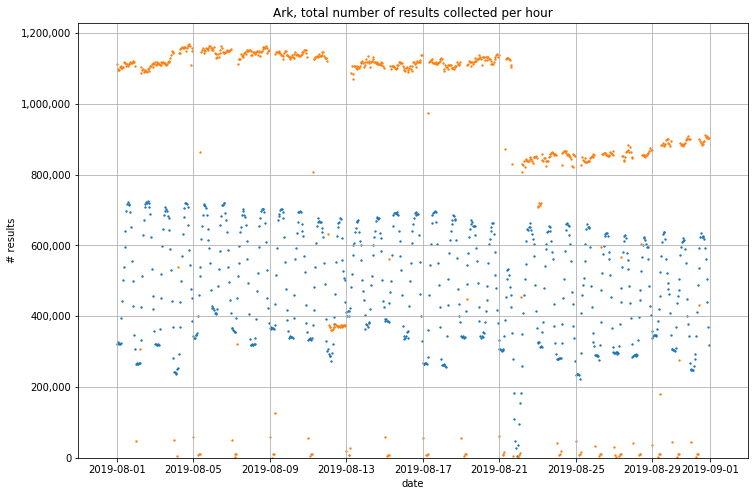

In [13]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()

#ax    = ark_results_ipv6.plot(ax=ax, x='ts', y='count', label="Ark IPv6")
#ax    = ark_results_ipv4.plot(ax=ax, x='ts', y='count', label="Ark IPv4")

plt.scatter(ark_results_ipv6['ts'], ark_results_ipv6['count'], label="Ark IPv6", s=1.8)
plt.scatter(ark_results_ipv4['ts'], ark_results_ipv4['count'], label="Ark IPv4", s=1.8)

ax.grid(True)
ax.set_xlabel('date')
ax.set_ylabel('# results')
ax.set_title("Ark, total number of results collected per hour")
ax.set_xlim(left="2019-07-30", right="2019-09-03")
ax.set_ylim(bottom=0)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.ylim(ymin = 0)

#plt.show()


This clearly isn't quite right.

The raw data looks more stable, so I **think** the data is being fetched once and uploaded (but earlier directories are not re-fetched; unsure if Elena has rsync access or if this is all via http)



# Target Diversity

The above refers to the number of measurement results (i.e., the number of traceroutes returned); it says nothing of the targets measured or the hops travered.

First, it's easy to count the number of targets each type of measurement used:

In [4]:
%%bigquery target_counts_v4

SELECT    DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, COUNT(DISTINCT dstAddress) as count
FROM     `data-test-194508.caida.ark_traces_ipv4`
GROUP BY  ts
ORDER BY  ts

In [5]:
%%bigquery target_counts_v6

SELECT    DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, COUNT(DISTINCT dstAddress) as count
FROM     `data-test-194508.caida.ark_traces_ipv6`
GROUP BY  ts
ORDER BY  ts

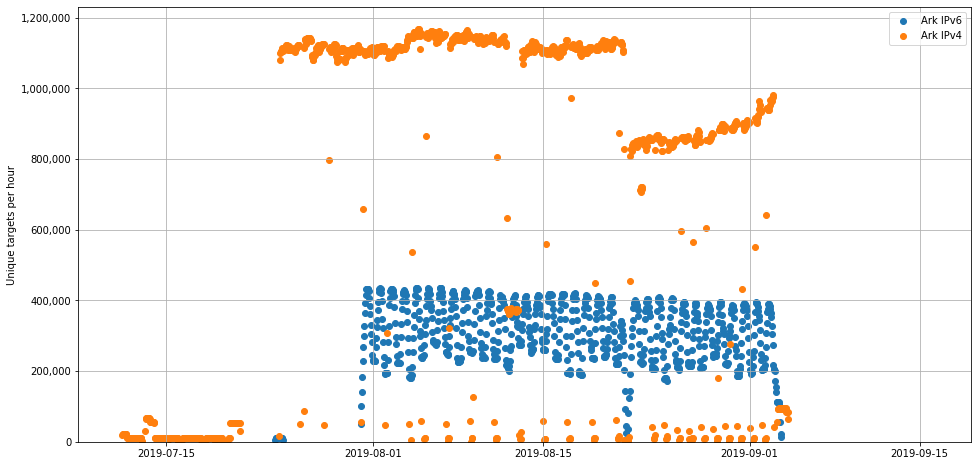

In [20]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()

#ax    = target_counts_v6.plot(ax=ax, x='ts', y='count', label="Ark IPv6")
#ax    = target_counts_v4.plot(ax=ax, x='ts', y='count', label="Ark IPv4")
plt.scatter(target_counts_v6['ts'], target_counts_v6['count'], label="Ark IPv6")
plt.scatter(target_counts_v4['ts'], target_counts_v4['count'], label="Ark IPv4")

ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('Unique targets per hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.ylim(ymin = 0)
plt.legend(loc='best')
#plt.show()


## Distinct ASNs targetted

Note: not distinct ASNs observed responsive in traceroutes.

In [8]:
%%bigquery target_asn_counts_v4

WITH ips AS (
  SELECT    DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, dstAddress AS target
  FROM     `data-test-194508.caida.ark_traces_ipv4`
),
bgp AS (
  SELECT distinct ip, ARRAY_TO_STRING(ARRAY(SELECT a FROM UNNEST(origins) a ORDER BY a), ",") AS origins
  FROM `data-test-194508.sds_test.analysis_ark_v4_lpm`
),
matched AS (
  SELECT *
  FROM ips
  JOIN bgp
  ON   target = ip
)

SELECT   ts, count(distinct origins) as count
FROM     matched
GROUP BY ts
ORDER BY ts

In [9]:
%%bigquery target_asn_counts_v6

-- hour, target
WITH ips AS (
  SELECT    DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, dstAddress AS target
  FROM     `data-test-194508.caida.ark_traces_ipv6`
),
-- ip, list_of_origins
bgp AS (
  SELECT distinct ip, ARRAY_TO_STRING(ARRAY(SELECT a FROM UNNEST(origins) a ORDER BY a), ",") AS origins
  FROM `data-test-194508.sds_test.analysis_ark_v6_lpm`
),
-- join both tables
matched AS (
  SELECT *
  FROM ips
  JOIN bgp
  ON   target = ip
)

-- count distinct origins per hour
SELECT   ts, count(distinct origins) as count
FROM     matched
GROUP BY ts
ORDER BY ts

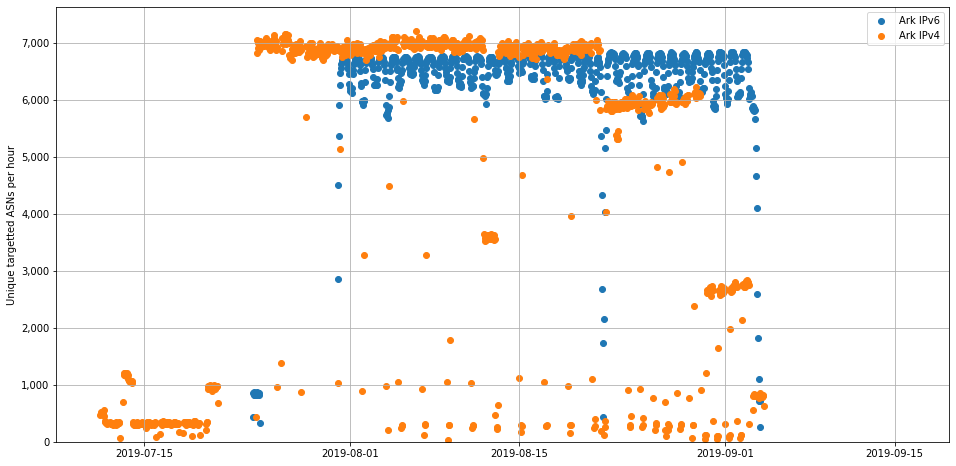

In [18]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()

#ax    = target_asn_counts_v6.plot(ax=ax, x='ts', y='count', label="Ark IPv6")
#ax    = target_asn_counts_v4.plot(ax=ax, x='ts', y='count', label="Ark IPv4")

plt.scatter(target_asn_counts_v6['ts'], target_asn_counts_v6['count'], label="Ark IPv6")
plt.scatter(target_asn_counts_v4['ts'], target_asn_counts_v4['count'], label="Ark IPv4")

ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('Unique targetted ASNs per hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.ylim(ymin = 0)
plt.legend(loc='best')
#plt.show()


## IPs, ASNs observed

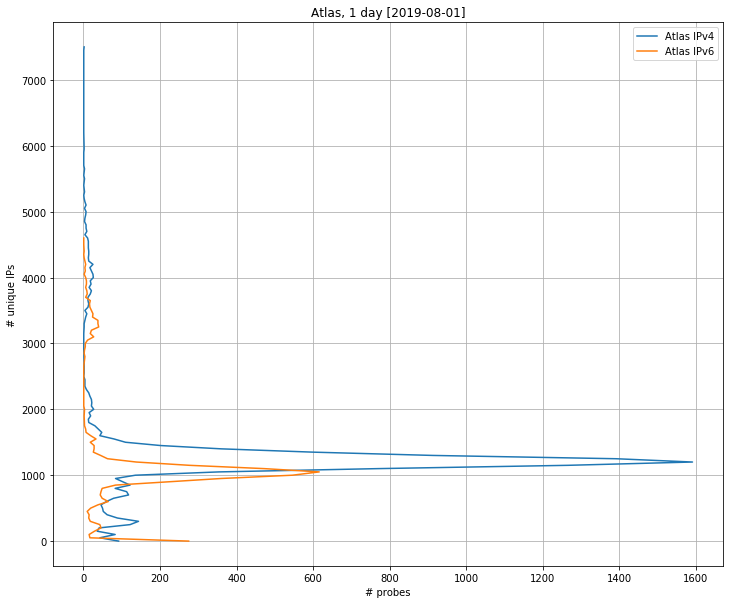

In [57]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots()
#ax = fig.add_subplot()

for af in [4, 6]:
        grp   = atlas_ip_prb_distrib_day[(atlas_ip_prb_distrib_day['af'] == af)]
        label = "Atlas IPv" + str(af)
        
        plt.plot(grp['num_prbs'], grp['num_ips'], label=label)


ax.grid(True)
ax.set_title("Atlas, 1 day [2019-08-01]")
ax.set_xlabel('# probes')
ax.set_ylabel('# unique IPs')
ax.legend(loc='best')

In [26]:
%%bigquery ark_ip_prb_distrib_week

WITH foo AS
(
  select  4 as af, srcAddress, h.hopAddress as ip
  from   `data-test-194508.caida.ark_traces_ipv4`, unnest(hops) h
  WHERE   startTime >= "2019-08-01T00:00:00" AND startTime < "2019-08-08T00:00:00"
),
distribution AS
(
  --SELECT   af, srcAddress, ARRAY_LENGTH(ARRAY_AGG(distinct ip)) num_ips
  SELECT   af, srcAddress, count(distinct ip) as num_ips
  FROM     foo
  GROUP BY srcAddress, af
),
counts AS
(
  SELECT   af, COUNT(*) as num_prbs, num_ips
  FROM     distribution
  GROUP BY af, num_ips
)

SELECT af, SUM(num_prbs) AS num_prbs, CAST(num_ips / 50  AS INT64) * 50 AS num_ips
FROM   counts
GROUP BY af, num_ips
ORDER BY num_ips, num_prbs


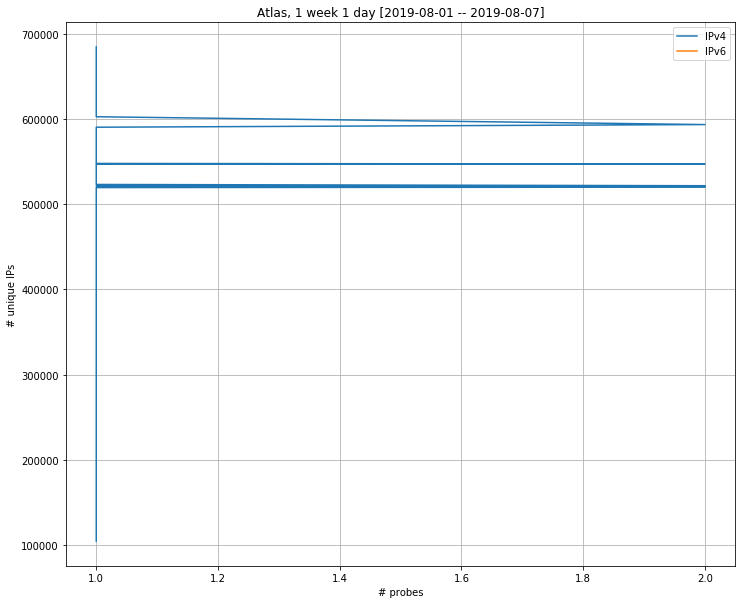

In [27]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots()

for af in [4, 6]:
        grp   = ark_ip_prb_distrib_week[(ark_ip_prb_distrib_week['af'] == af)]
        label = "IPv" + str(af)
        plt.plot(grp['num_prbs'], grp['num_ips'], label=label)

ax.grid(True)
ax.set_title("Atlas, 1 week 1 day [2019-08-01 -- 2019-08-07]")
ax.set_xlabel('# probes')
ax.set_ylabel('# unique IPs')
ax.legend(loc='best')

In [13]:
%%bigquery v4_all_responding_addr_first_seen

WITH times AS (
  SELECT min(startTime) as first_ts, h.hopAddress as ip
  FROM `data-test-194508.caida.ark_traces_ipv4`, UNNEST(hops) as h
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-09-01T00:00:00"
  GROUP BY ip
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-08-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts


In [12]:
%%bigquery v6_all_responding_addr_first_seen

WITH times AS (
  SELECT min(startTime) as first_ts, h.hopAddress as ip
  FROM `data-test-194508.caida.ark_traces_ipv6`, UNNEST(hops) as h
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-09-01T00:00:00"
  GROUP BY ip
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-08-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts


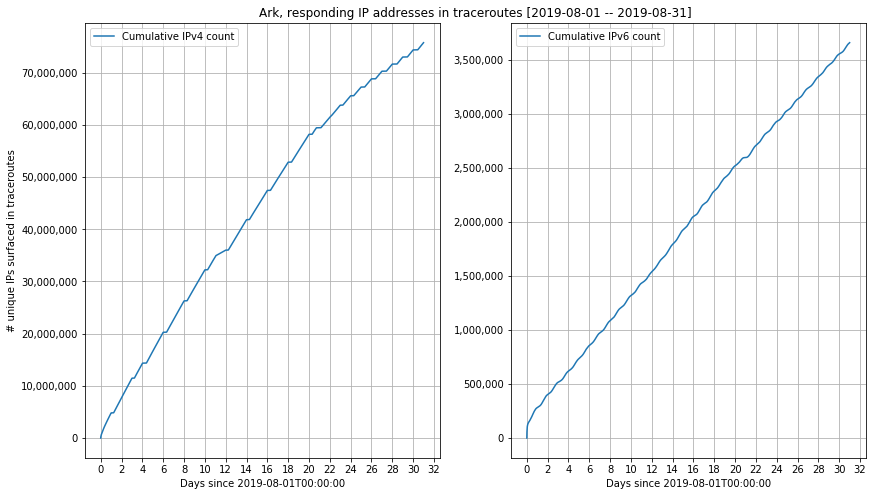

In [15]:
import arrow
import numpy as np
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()
#ax.axis('off')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', which='both', top='off', bottom='off', left='off', right='off', length=0)
#ax.get_yaxis().set_visible(False)
#ax.get_xaxis().set_visible(False)
ax.set_title("Ark, responding IP addresses in traceroutes [2019-08-01 -- 2019-08-31]")

ticks = np.arange(0, 3000000, 172800)

ax1 = fig.add_subplot(1,2,1)
ax1.set_xticks(ticks)
ax1.grid(True)
ax1.set_xlabel('Days since 2019-08-01T00:00:00')
ax1.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/86400), ','))
)
ax1.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)
# Set top of plot and draw horizontal line
plt.plot(v4_all_responding_addr_first_seen['ts_delta'], v4_all_responding_addr_first_seen['total'], label="Cumulative IPv4 count")
ax1.legend(loc='best')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xticks(ticks)
ax2.grid(True)
ax2.set_xlabel('Days since 2019-08-01T00:00:00')
ax2.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/86400), ','))
)
ax2.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

plt.plot(v6_all_responding_addr_first_seen['ts_delta'], v6_all_responding_addr_first_seen['total'], label="Cumulative IPv6 count")
ax2.legend(loc='best')

ax1.set_ylabel('# unique IPs surfaced in traceroutes')
plt.show()


In [5]:
%%bigquery atlas_ip_prb_distrib

WITH foo AS (
  select af, prbId, rh.from as f
  from   `data-test-194508.prod.traceroute_atlas_prod`, unnest(hops), unnest(resultHops) rh
  WHERE startTime > "2019-08-01" AND startTime < "2019-08-02"
),
distribution AS (
  SELECT f, af, ARRAY_LENGTH(ARRAY_AGG(distinct prbId)) AS num_prbs
  FROM   foo
  GROUP BY f, af
)

SELECT af, COUNT(*) as num_ips, num_prbs
FROM   distribution
GROUP BY af, num_prbs
ORDER BY num_ips, num_prbs

In [ ]:
%%bigquery v6_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv6"

In [4]:
%%bigquery v4_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv4"

In [5]:
%%bigquery v6_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv6"